# MAUT assessment of predicted environmentally relevant properties and synthesizability (PBMTS scoring) of *in silico* generated structure suggestions for chemical redesign


### Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import openpyxl

from itertools import groupby
from IPython.display import Image
from functools import reduce

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
DrawingOptions.includeAtomNumbers=True
from rdkit.Chem.Draw import rdMolDraw2D

from IPython.display import SVG

import matplotlib.pyplot as plt
from matplotlib import rc

import seaborn as sns

from scipy.interpolate import interp1d

## Import Data
Import big dataframe contianing all structures which were assessed ready biodegradable by the Biowin 3 and 5 cut-off and their predicted properties, excluding chemically unstable enols (32 350 structures).

In [2]:
BigDF_raw = pd.read_csv('C:\\Users\\Hannah\\OneDrive - UvA\\Master UvA\\master project\\design_additions_after_msc\\insilico_smiles_properties.txt', sep='\t', index_col=0)

In [3]:
#make a copy, chekc how data looks like
BigDF = BigDF_raw.copy()
print(len(BigDF))
print(BigDF.columns)
BigDF.head()

32350
Index(['SMILES', 'Inchi', 'Inchikey', 'vegaSMILES', 'log Kow', 'log koc',
       'BCF', 'Assessment', 'Used models',
       'Predicted Consensus Mutagen activity', 'Mutagenic Score',
       'Non-Mutagenic Score', 'Model Caesar assessment',
       'Model ISS assessment', 'Model SarPy assessment',
       'Model KNN assessment', 'Remarks', 'Biowin1', 'Biowin2', 'Biowin3',
       'Biowin4', 'Biowin5', 'Biowin6', 'Biowin7',
       'KOC model (OPERA) - assessment',
       'KOC model (OPERA) - prediction [log(L/Kg)]',
       'Estrogen Receptor-mediated effect (IRFMN/CERAPP) - assessment',
       'Estrogen Receptor-mediated effect (IRFMN/CERAPP) - prediction',
       'Androgen Receptor-mediated effect (IRFMN/COMPARA) - assessment',
       'Androgen Receptor-mediated effect (IRFMN/COMPARA) - prediction',
       'Thyroid Receptor Alpha effect (NRMEA) - assessment',
       'Thyroid Receptor Alpha effect (NRMEA) - prediction',
       'Thyroid Receptor Beta effect (NRMEA) - assessment',
     

,SMILES,Inchi,Inchikey,vegaSMILES,log Kow,log koc,BCF,Assessment,Used models,Predicted Consensus Mutagen activity,...,KOC model (OPERA) - assessment,KOC model (OPERA) - prediction [log(L/Kg)],Estrogen Receptor-mediated effect (IRFMN/CERAPP) - assessment,Estrogen Receptor-mediated effect (IRFMN/CERAPP) - prediction,Androgen Receptor-mediated effect (IRFMN/COMPARA) - assessment,Androgen Receptor-mediated effect (IRFMN/COMPARA) - prediction,Thyroid Receptor Alpha effect (NRMEA) - assessment,Thyroid Receptor Alpha effect (NRMEA) - prediction,Thyroid Receptor Beta effect (NRMEA) - assessment,Thyroid Receptor Beta effect (NRMEA) - prediction
0,CCCCOP(=O)(OCN)OCCCC,"InChI=1S/C9H22NO4P/c1-3-5-7-12-15(11,14-9-10)1...",FQZURDOEFGTKDH-UHFFFAOYSA-N,O=P(OCN)(OCCCC)OCCCC,1.42,2.637089,0.6043,NON-Mutagenic (Consensus score: 0.375),4,NON-Mutagenic,...,2.4243 log(L/Kg) (low reliability),2.4243,NON-active (low reliability),NON-active,NON-active (moderate reliability),NON-active,Inactive (good reliability),Inactive,Inactive (good reliability),Inactive
1,CCCCCOP(=O)(OCN)OCCCC,"InChI=1S/C10H24NO4P/c1-3-5-7-9-14-16(12,15-10-...",HFYGOQQKIGXYQR-UHFFFAOYSA-N,O=P(OCN)(OCCCC)OCCCCC,1.91,2.897737,1.2740,NON-Mutagenic (Consensus score: 0.525),4,NON-Mutagenic,...,2.3714 log(L/Kg) (low reliability),2.3714,NON-active (low reliability),NON-active,NON-active (moderate reliability),NON-active,Inactive (good reliability),Inactive,Inactive (good reliability),Inactive
2,CCCCOP(=O)(OCCN)OCCCC,"InChI=1S/C10H24NO4P/c1-3-5-8-13-16(12,15-10-7-...",JDDLUVXBUHFTCI-UHFFFAOYSA-N,O=P(OCCN)(OCCCC)OCCCC,1.37,2.897737,0.5531,NON-Mutagenic (Consensus score: 0.6),4,NON-Mutagenic,...,2.4166 log(L/Kg) (moderate reliability),2.4166,Not predicted (low reliability),Not predicted,NON-active (moderate reliability),NON-active,Inactive (good reliability),Inactive,Inactive (good reliability),Inactive
3,CCCCCOP(=O)(OC)OCNCCCC,"InChI=1S/C11H26NO4P/c1-4-6-8-10-15-17(13,14-3)...",PZRNSLQIRKYCIG-UHFFFAOYSA-N,O=P(OC)(OCNCCCC)OCCCCC,2.38,2.945665,2.5860,NON-Mutagenic (Consensus score: 0.35),4,NON-Mutagenic,...,2.7467 log(L/Kg) (moderate reliability),2.7467,NON-active (moderate reliability),NON-active,NON-active (moderate reliability),NON-active,Inactive (good reliability),Inactive,Inactive (good reliability),Inactive
4,CCCCCNCOP(=O)(OC)OCCCC,"InChI=1S/C11H26NO4P/c1-4-6-8-9-12-11-16-17(13,...",FIXQROCYSXZKQD-UHFFFAOYSA-N,O=P(OC)(OCNCCCCC)OCCCC,2.38,2.945665,2.5860,NON-Mutagenic (Consensus score: 0.3),4,NON-Mutagenic,...,2.7454 log(L/Kg) (moderate reliability),2.7454,NON-active (moderate reliability),NON-active,NON-active (moderate reliability),NON-active,Inactive (good reliability),Inactive,Inactive (good reliability),Inactive


### Check log Kow and MW range
relevant for model applicability

In [4]:
print('Maximum log Kow in dataset (Episuite KOWWIN pred.):',BigDF['log Kow'].max(),
      'Minimum log Kow in dataset:',BigDF['log Kow'].min())

Maximum log Kow in dataset (Episuite KOWWIN pred.): 6.27 Minimum log Kow in dataset: -5.26


In [5]:
BigDF['MW'] = [Chem.Descriptors.MolWt(Chem.MolFromSmiles(BigDF['SMILES'][x])) for x in BigDF.index]

In [6]:
print('Maximum MW in dataset:',BigDF['MW'].max(),
      'Minimum MW in dataset:',BigDF['MW'].min())

Maximum MW in dataset: 336.45300000000015 Minimum MW in dataset: 180.05199999999996


## Toxicity filters

#### Filter out mutagenic structures
According to VEGA Mutagenicity (Ames test) consensus model (version 1.0.3)

In [7]:
#Only save rows with property non-mutagenic in BigDF = drop all mutagenic compounds
BigDF = BigDF[BigDF['Predicted Consensus Mutagen activity']== 'NON-Mutagenic']
#check length of dataset
len(BigDF)

31293

#### Filter out structures with endocrine activity


Assessments of models Estrogen Receptor-mediated effect (IRFMN/CERAPP), Thyroid Receptor Alpha effect (NRMEA), and Thyroid Receptor Beta effect (NRMEA), were not active for all strucutres in the dataset.
Structures predicted as active in model Androgen Receptor-mediated effect (IRFMN/COMPARA) are filtered out.

In [8]:
EDC_models = ['Estrogen Receptor-mediated effect (IRFMN/CERAPP) - prediction',
       'Androgen Receptor-mediated effect (IRFMN/COMPARA) - prediction',
       'Thyroid Receptor Alpha effect (NRMEA) - prediction',
       'Thyroid Receptor Beta effect (NRMEA) - prediction']
#check what predictions exist in dataset
for model in EDC_models:
    print(BigDF[model].value_counts())

NON-active             18128
Possible NON-active     8271
Not predicted           4894
Name: Estrogen Receptor-mediated effect (IRFMN/CERAPP) - prediction, dtype: int64
NON-active    31247
Active           46
Name: Androgen Receptor-mediated effect (IRFMN/COMPARA) - prediction, dtype: int64
Inactive    31293
Name: Thyroid Receptor Alpha effect (NRMEA) - prediction, dtype: int64
Inactive    31293
Name: Thyroid Receptor Beta effect (NRMEA) - prediction, dtype: int64


In [9]:
#Only save rows with property non active in BigDF = drop all EDC structures
before = len(BigDF)
BigDF = BigDF[BigDF['Androgen Receptor-mediated effect (IRFMN/COMPARA) - prediction']!= 'Active']
print(before - len(BigDF), 'Structures were filtered out.')
#check length of dataset
print('Dataframe now contains ',len(BigDF),' structures.')

46 Structures were filtered out.
Dataframe now contains  31247  structures.


Structures which were filtered out due to predicted androgenic activity: 


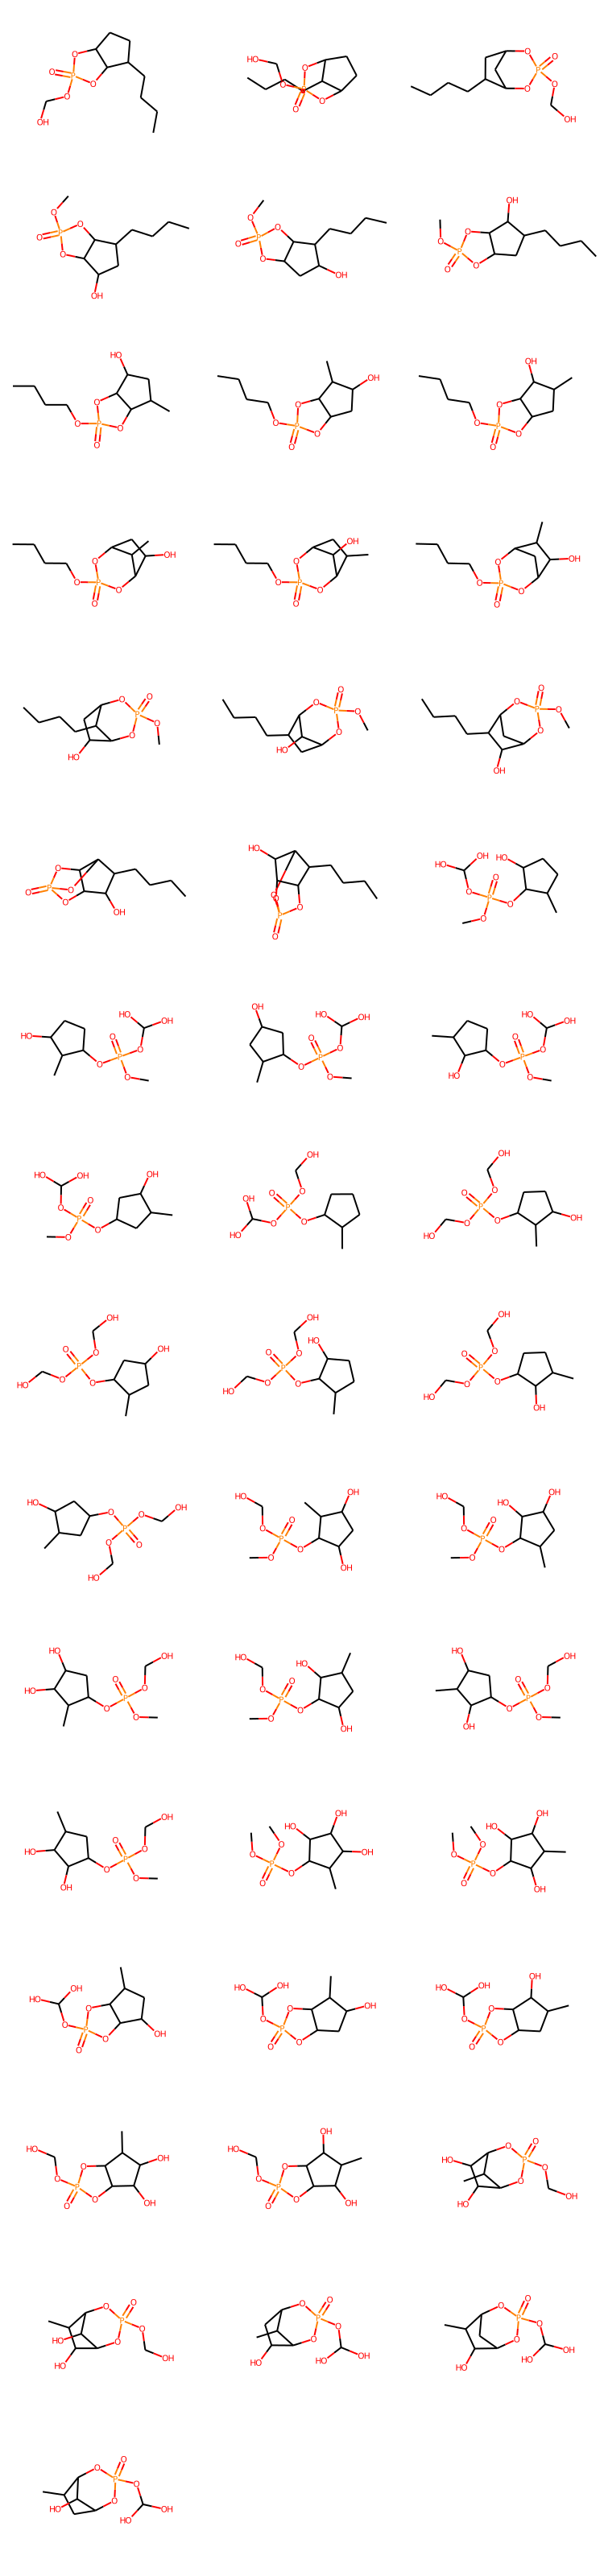

In [10]:
#general functions to visualize structures
def show_mol_grid(mols):
    '''draws molecules in grid, needs to be last command in cell'''
    return MolsToGridImage(mols
        , subImgSize=(250,200)
        ,molsPerRow=3)

def drawsmileslist(smileslist):
    '''draws molecules from list of smiles in grid, needs to be last command in cell'''
    mols = []
    for smiles in smileslist:
        mols.append(Chem.MolFromSmiles(smiles))
    return(show_mol_grid(mols))

#visualize the structures which were filtered out as Androgenic active compounds
print('Structures which were filtered out due to predicted androgenic activity: ')
drawsmileslist(BigDF_raw[BigDF_raw['Androgen Receptor-mediated effect (IRFMN/COMPARA) - prediction']== 'Active']['SMILES'])

## MAUT assessment

MAUT = Multi attribute utility theory


Attributes to evaluate in the following multi-criteria desision analysis:

Persistency:
* log Kow predicted by KOWWIN model from EPISUITE
* aerobic biodegradation predicted by Biowin 3+6 models from EPISUITE
* anaerobic biodegradation predicted by Biowin 7 model from EPISUITE

Bioaccumulation:
* BCF predicted by BCFBAF from EPISUITE is excluded from the MAUT assessment as all strucutures in the dataset have low values much below the hazard treshhold.

Mobility:
* log Koc as average of predictions by KOCWIN model from EPISUITE and OPERA KOC model from VEGA 

Toxicity:
* Mutagenity as Non-mutagenic score predicted by VEGA consensus model

Syntheziability:
* reward for symmentry in phosphate side chains
* penalty for 3- or 4-membered rings

For each property, a MAUT score is created, normalized to the range of values in the dataset. For LogKoc and LogKow desirability functions are defined to create the MAUT score, as both too high and a too low values are not desirable. For aerobic biodegradation, individual MAUT scores are created for models Biowin 3 and Biowin 6 and these MAUT scores are then averaged for a total aerobic biodegradability MAUT score. 

Individual scored are combined for a final ranking of the structure suggestions in the dataset.


### Functions for MAUT assessment

In [11]:
#Functions created for MAUT analysis
def applyPositiveMAUT(val_att, min_att, max_att):
    '''The higher the better: Measures distance of value form minimum relative to maximum distance, which is equal to dividing range.'''
    des_score = (val_att - min_att) / (max_att - min_att)
    return des_score
    
def applyNegativeMAUT(val_att, min_att, max_att):
    '''The lower the better: Measures distance of value to maximum realtive to maximum distance, which is equal to dividing by range'''
    des_score = (max_att - val_att) / (max_att - min_att)
    return des_score

def createMAUTScoresForAttribute(df, attribute,relation):
    '''Appends a column to df with MAUT desirability scores for the attibute speficied, relation must be "positive", 
    so the higher the better, or "negative", so the lower the better. Attribute must be specified as in column name. 
    Prints minimum and maximum vlaues for attribute in df. '''
    min_attribute = df[attribute].min()
    print("The minimum ",attribute," in the dataset is ", min_attribute)
    max_attribute = df[attribute].max()
    print("The maximum ",attribute," in the dataset is ", max_attribute)
    df[str(attribute + '_MAUTscore')] = float(0)
    if relation == "positive":
        for index,row in df.iterrows():
            df[str(attribute + '_MAUTscore')][index] = float(applyPositiveMAUT(df[attribute][index],min_attribute, max_attribute))
    elif relation == "negative":
        for index,row in df.iterrows():
            df[str(attribute + '_MAUTscore')][index] = float(applyNegativeMAUT(df[attribute][index],min_attribute, max_attribute))
    else:
        print("Relation argument invalid! No columns created.")
    return df

#Create MAUT scores for log Kow and log Koc
def createMAUTscoreFromFunction(df, attribute, des_function):
    '''Creates MAUT score for attribute, provided as in dataframe column, 
    according to specified desirability function in new column. 
    Returns new df with column added.'''
    des_columnname= str(attribute + '_MAUTscore')
    df[des_columnname] = float(0)
    for index,row in df.iterrows():
        df[des_columnname][index] = df[des_columnname][index].astype(float) + float(des_function(df[attribute][index]))
    return df


#### Log Kow desirability function

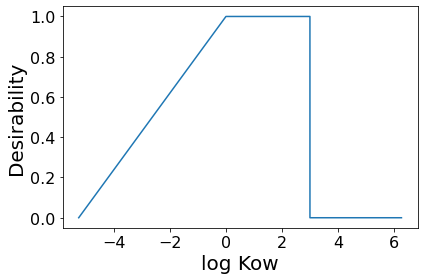

In [12]:
#logKow desirability function
#use these points to design the desirability curve:
logKow_desirability_points = [{"x": BigDF['log Kow'].min(), "y": 0}, {"x": 0, "y": 1}, 
                       {"x": 3.0, "y": 1}, {"x": 3.001, "y": 0} ,{"x": BigDF['log Kow'].max(), "y": 0}  ]
logKow_desirability = pd.DataFrame(logKow_desirability_points)
f_logKow = interp1d(logKow_desirability['x'],logKow_desirability['y'], kind='linear')

#plot to see desirability function
plt.plot(logKow_desirability['x'],f_logKow(logKow_desirability['x']))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('log Kow',fontsize=20)
plt.ylabel('Desirability',fontsize=20)
plt.tight_layout()
plt.show()
#plt.savefig('logKow', dpi=1800)

#### Log Koc desirability function

In [13]:
#Average log Koc from Episuite KOCWIN and from VEGA opera model
BigDF['log Koc_av'] = 0.5*BigDF['KOC model (OPERA) - prediction [log(L/Kg)]']+0.5*BigDF['log koc']

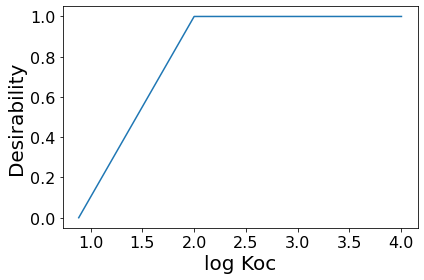

In [14]:
#logKoc desirability function
#use these points to design the desirability curve:
logKoc_desirability_points = [{"x": BigDF['log Koc_av'].min(), "y": 0},{"x": 2, "y": 1},{"x": 4, "y": 1},
                           {"x":BigDF['log Koc_av'].max(), "y": 1} ]

logKoc_desirability = pd.DataFrame(logKoc_desirability_points)
f_logKoc = interp1d(logKoc_desirability['x'],logKoc_desirability['y'], kind='linear')

#plot to see desirability function
plt.plot(logKoc_desirability['x'],logKoc_desirability['y'])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('log Koc', fontsize=20)
plt.ylabel('Desirability', fontsize=20)
plt.tight_layout()
plt.show()
#plt.savefig('logKoc', dpi=1800)

### Create individual MAUT scores per attribute

In [15]:
#don't display warnings in output
import warnings
warnings.filterwarnings('ignore')
#create MAUT scores linearly for properties (=attibutes)
BigDF = createMAUTScoresForAttribute(BigDF, "Biowin3", 'positive')
BigDF = createMAUTScoresForAttribute(BigDF, "Biowin6", 'positive')
BigDF = createMAUTScoresForAttribute(BigDF, "Biowin7", 'positive')
BigDF = createMAUTScoresForAttribute(BigDF, 'Non-Mutagenic Score', 'positive')
#create MAUT scores according to desirability funcitons
BigDF = createMAUTscoreFromFunction(BigDF, 'log Kow', f_logKow)
print('Minimum log Kow: ',BigDF['log Kow'].min(),
      'Maximum log Kow: ',BigDF['log Kow'].max())
BigDF = createMAUTscoreFromFunction(BigDF, 'log Koc_av',f_logKoc)
print('Minimum log Koc: ',BigDF['log Koc_av'].min(),
      'Maximum log Koc: ',BigDF['log Koc_av'].max())

The minimum  Biowin3  in the dataset is  3.2513
The maximum  Biowin3  in the dataset is  3.7969
The minimum  Biowin6  in the dataset is  0.1726
The maximum  Biowin6  in the dataset is  0.9806
The minimum  Biowin7  in the dataset is  0.3307
The maximum  Biowin7  in the dataset is  1.9981
The minimum  Non-Mutagenic Score  in the dataset is  0.15
The maximum  Non-Mutagenic Score  in the dataset is  1.0
Minimum log Kow:  -5.26 Maximum log Kow:  6.27
Minimum log Koc:  0.88415 Maximum log Koc:  4.0040009064226405


In [16]:
#combine Biowin 3 and 6 MAUT scores to ReadyBiodegBW36 attribute MAUT score by average
BigDF['ReadyBiodegBW36_MAUTscore'] = float(0)
for index,row in BigDF.iterrows():
    BigDF['ReadyBiodegBW36_MAUTscore'][index] = float((BigDF['Biowin3_MAUTscore'][index]+BigDF['Biowin6_MAUTscore'][index])/2)

Check the generation of MAUT scores according to desirbaility functions: The distribution of the MAUT scores for Log Kow and Log Koc follow the respective desirability functions. 

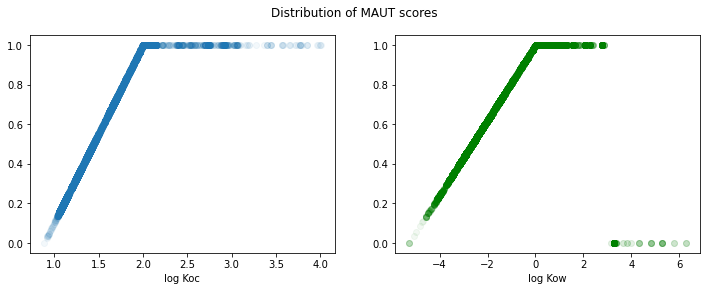

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle('Distribution of MAUT scores')
ax1.scatter(BigDF['log Koc_av'],BigDF['log Koc_av_MAUTscore'], alpha=0.05)
ax1.set_xlabel('log Koc')
ax2.scatter(BigDF['log Kow'],BigDF['log Kow_MAUTscore'], alpha=0.05, color='g')
ax2.set_xlabel('log Kow')
plt.show()

### Create Synthesizability scores (SynSym Points, SynRing Points)
Here, a criterion for synthesizability is included in the scoring approach. 
This cosiders the "symmetry" of the organophosphorus side chains (SynSym Points), as we assume molecules with two or three same side chains are easier to synthesize, and penalizes high-strain rings with 3 or 4 memebers (SynRing Points), as these are also generally challenging to introduce during synthesis. <br>
The SynSym Points assigned are 0 (=all side chains different), 1 (=two side chains equal) or 2 (all side chains equal).  The SynRing Points are -1 per such ring. 
<br>Furthermore, these rings rarely appear in the training datasets of the models used to predict properties, which makes the estimates for these kind of structures less reliable.

#### Functions for synthesizability scores

In [18]:
phosphatecore = Chem.MolFromSmiles('O=P(O)(O)O')

def getsidechainsSMILES(core, molsmiles):
    '''input one molecule as smiles, core as mol! Removes core and gives sidechains with dummies 
    removed as smiles list'''
    mol = Chem.MolFromSmiles(molsmiles)
    fragments1 = Chem.ReplaceCore(mol, core)
    #split coreremoved smiles into fragments and remove dummy starting atoms
    fragments = [f[4:] for f in Chem.CanonSmiles(Chem.MolToSmiles(fragments1)).split('.')] 
    return fragments

def atomsInConnectedRings(molsmiles):
    '''input one molecule as smiles, returns 2 if molecule contains two connected rings, 3 if three connected rings, 
    4 if four connected rings, 0 if none'''
    mol = Chem.MolFromSmiles(molsmiles)
    member_of_two_rings_smarts = '[R2]'
    member_of_three_rings_smarts = '[R3]'
    member_of_four_rings_smarts = '[R4]'
    points = 0
    if mol.HasSubstructMatch(Chem.MolFromSmarts(member_of_two_rings_smarts)):
        points = 2
    elif mol.HasSubstructMatch(Chem.MolFromSmarts(member_of_three_rings_smarts)):
        points = 3
    elif mol.HasSubstructMatch(Chem.MolFromSmarts(member_of_four_rings_smarts)):
        points = 4 
    return points

def membersOfRings(molsmiles):
    '''input one molecule as smiles, returns list of ring sizes in molecule, 0 if no ring. 
    Can return wrong results for complex molecules, e.g. does not recognize six mebered ring in camphor'''
    mol = Chem.MolFromSmiles(molsmiles)
    ring_sizes = [3,4,5,6,7,8]
    ring_sizes_in_mol = [0]
    for ring_size in ring_sizes:
        atoms_in_x_mem_ring = str('[r'+str(ring_size)+']')
        if mol.HasSubstructMatch(Chem.MolFromSmarts(atoms_in_x_mem_ring)):
            ring_sizes_in_mol.append(ring_size)
    return ring_sizes_in_mol

def Syn34RingPoints(molsmiles):
    '''input molecule as smiles, creates SynRingPoints, 
    -1 if three or four membered rings, otherwise 0.'''
    points = 0
    if any(number in membersOfRings(molsmiles) for number in [3,4]):
        points = -1
    return points

def getSynRingPoints(indf):
    '''generates points of 0, or -1 when 3 or 4 membered rings are contained in structure in new column'''
    df = indf.copy()
    df['SynRingPoints'] = float(0)
    for index,row in df.iterrows():
        df['SynRingPoints'][index] = float(Syn34RingPoints(df['SMILES'][index]))
    return df

def SynSymPoints(core, molsmiles):
    """input core to be removed as mol and molecule as smiles, creates SynSymPoints, 
    synthesizability points based on symmetry of side chains."""
    frags = getsidechainsSMILES(core, molsmiles)
    duplifrags = len(frags)-len(set(frags))
    #normalize to 1
    points = duplifrags/2
    return points

def getSynSymPoints(indf):
    """generates SynSymPoints for all smiles in df by substracting phosphate core and comparing sidechains
    and appends as new column with points (0=all three sidechains different, 1=one pair, 2=all sidechains same,
    returns new df"""
    df = indf.copy()
    df['SynSymPoints'] = float(0)
    for index,row in df.iterrows():
        df['SynSymPoints'][index] = float(SynSymPoints(phosphatecore,df['SMILES'][index]))
    return df

#### Apply synthesizability functions to dataset

In [19]:
#Create independent copy of BigDF
MAUT_data = BigDF.copy()

In [20]:
MAUT_data_SynSymPoints = getSynSymPoints(MAUT_data)

In [21]:
MAUT_data_SynPoints = getSynRingPoints(MAUT_data_SynSymPoints)

In [22]:
BigDF = MAUT_data_SynPoints.copy()

### Set weights and create total MAUT PBMTS scores

To obtain a total MAUT score for PMTS properties (as B is not relevant for these structures), the MAUT scores for the individual properties are multiplied with weight factors, summed up and normalized. Subsequently, the structures in the dataset are ranked according to this total PMT score.
#### Set weight factors for total score generation

In [23]:
#P - 2
weight_logKow = 1
weight_BW36 = 0.5
weight_BW7 = 0.5
#M - 1
weight_logKoc = 1 #average VEGA and Epi
#T - 1
weight_NonMuta = 1
#S - 1
weight_sym = 0.5
weight_ring = 0.5
weight_factors_list_PMT = [weight_logKow, weight_BW36, weight_BW7, weight_logKoc,
                       weight_NonMuta]
weight_factors_list_all = [weight_logKow, weight_BW36, weight_BW7, weight_logKoc,
                       weight_NonMuta, weight_sym, weight_ring]

normalize_factor_PMT = 1/sum(weight_factors_list_PMT) #to normalize weights to 1
normalize_factor_PMTS = 1/sum(weight_factors_list_all) #to normalize weights to 1

#### Create total PMT score and rank accordingly

In [24]:
#Combine all PMT attribute scores to one score
BigDF['total_PMTscore'] = float(0)
for index,row in BigDF.iterrows():
    BigDF['total_PMTscore'][index] = float((weight_logKow * BigDF['log Kow_MAUTscore'][index]+ 
                                             weight_logKoc * BigDF['log Koc_av_MAUTscore'][index]+
                                             weight_BW36 * BigDF['ReadyBiodegBW36_MAUTscore'][index]+
                                             weight_BW7 * BigDF['Biowin7_MAUTscore'][index]+
                                             weight_NonMuta * BigDF['Non-Mutagenic Score_MAUTscore'][index])
                                            * normalize_factor_PMT #normalize weights to 1
                                           )

In [25]:
#rank according to total PMT MAUT score
BigDF['total_PMTrank']= BigDF['total_PMTscore'].rank(ascending=False, method='min')
BigDF = BigDF.sort_values('total_PMTscore', ascending=False)
top500_PMTtotal = BigDF.head(500)
top500_PMTtotal

,SMILES,Inchi,Inchikey,vegaSMILES,log Kow,log koc,BCF,Assessment,Used models,Predicted Consensus Mutagen activity,...,Biowin6_MAUTscore,Biowin7_MAUTscore,Non-Mutagenic Score_MAUTscore,log Kow_MAUTscore,log Koc_av_MAUTscore,ReadyBiodegBW36_MAUTscore,SynSymPoints,SynRingPoints,total_PMTscore,total_PMTrank
3249,CCCCCCCOP(=O)(OCCO)OCCCO,"InChI=1S/C12H27O6P/c1-2-3-4-5-6-10-16-19(15,18...",YINMNSAKUVYPDP-UHFFFAOYSA-N,O=P(OCCO)(OCCCO)OCCCCCCC,1.30,1.256477,0.4973,NON-Mutagenic (Consensus score: 0.825),4,NON-Mutagenic,...,0.847896,0.711587,0.794118,1.0,0.993851,0.479483,0.0,0.0,0.845876,1.0
2526,CCCCCCCOP(=O)(OCO)OCCCCO,"InChI=1S/C12H27O6P/c1-2-3-4-5-7-10-16-19(15,18...",JRQCJDASNNLLGU-UHFFFAOYSA-N,O=P(OCO)(OCCCCO)OCCCCCCC,1.30,1.256477,0.4973,NON-Mutagenic (Consensus score: 0.75),4,NON-Mutagenic,...,0.847896,0.711587,0.705882,1.0,1.000000,0.479483,0.0,0.0,0.825354,2.0
2797,CCCCCCCCCCOP(=O)(OCO)OCO,InChI=1S/C12H27O6P/c1-2-3-4-5-6-7-8-9-10-16-19...,PGINCQMLDSQFDW-UHFFFAOYSA-N,O=P(OCO)(OCO)OCCCCCCCCCC,1.30,1.256477,0.4973,NON-Mutagenic (Consensus score: 0.75),4,NON-Mutagenic,...,0.847896,0.711587,0.705882,1.0,1.000000,0.479483,0.5,0.0,0.825354,2.0
2541,CCCCOP(=O)(OCO)OCCCCCCCO,"InChI=1S/C12H27O6P/c1-2-3-10-16-19(15,18-12-14...",CAFWLDGDJFXCJI-UHFFFAOYSA-N,O=P(OCO)(OCCCC)OCCCCCCCO,1.30,1.256477,0.4973,NON-Mutagenic (Consensus score: 0.75),4,NON-Mutagenic,...,0.847896,0.711587,0.705882,1.0,1.000000,0.479483,0.0,0.0,0.825354,2.0
2538,CCCCCOP(=O)(OCO)OCCCCCCO,"InChI=1S/C12H27O6P/c1-2-3-7-10-16-19(15,18-12-...",INWPFKUXKMWVKD-UHFFFAOYSA-N,O=P(OCO)(OCCCCC)OCCCCCCO,1.30,1.256477,0.4973,NON-Mutagenic (Consensus score: 0.75),4,NON-Mutagenic,...,0.847896,0.711587,0.705882,1.0,1.000000,0.479483,0.0,0.0,0.825354,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,CCCCCOP(=O)(OCCCO)OC(O)CCC,"InChI=1S/C12H27O6P/c1-3-5-6-10-16-19(15,17-11-...",METRFLAHDJAZSL-UHFFFAOYSA-N,O=P(OCCCO)(OCCCCC)OC(O)CCC,1.22,1.201124,0.4447,NON-Mutagenic (Consensus score: 0.825),4,NON-Mutagenic,...,0.655198,0.533225,0.794118,1.0,0.725601,0.383134,0.0,0.0,0.744475,496.0
7738,CCCCCOP1(=O)OC(O)C(CCC)O1,InChI=1S/C10H21O5P/c1-3-5-6-8-13-16(12)14-9(7-...,DECQBSDUJVOCBI-UHFFFAOYSA-N,O=P1(OCCCCC)(OC(O)C(O1)CCC),1.11,1.755189,0.3765,NON-Mutagenic (Consensus score: 0.675),4,NON-Mutagenic,...,0.323762,0.553616,0.617647,1.0,1.000000,0.164172,0.0,0.0,0.744135,497.0
7603,CCCCOP1(=O)OC(CC)C(CO)O1,InChI=1S/C9H19O5P/c1-3-5-6-12-15(11)13-8(4-2)9...,XFTBKKAXSXHYOK-UHFFFAOYSA-N,O=P1(OCCCC)(OC(CO)C(O1)CC),0.62,1.514282,3.1620,NON-Mutagenic (Consensus score: 0.75),4,NON-Mutagenic,...,0.316213,0.538023,0.705882,1.0,0.903474,0.188807,0.0,0.0,0.743193,498.0
7803,CCCCOP1(=O)OC(C)C(CC)C(O)O1,InChI=1S/C10H21O5P/c1-4-6-7-13-16(12)14-8(3)9(...,ZVLWFWOXOQYJGM-UHFFFAOYSA-N,O=P1(OCCCC)(OC(O)C(CC)C(O1)C),1.04,1.708591,0.3367,NON-Mutagenic (Consensus score: 0.75),4,NON-Mutagenic,...,0.065470,0.498381,0.705882,1.0,1.000000,0.035026,0.0,0.0,0.743146,499.0


In [26]:
#Combine all PMTS attribute scores to one score
BigDF['total_PMTSscore'] = float(0)
for index,row in BigDF.iterrows():
    BigDF['total_PMTSscore'][index] = float((weight_logKow * BigDF['log Kow_MAUTscore'][index]+ 
                                             weight_logKoc * BigDF['log Koc_av_MAUTscore'][index]+
                                             weight_BW36 * BigDF['ReadyBiodegBW36_MAUTscore'][index]+
                                             weight_BW7 * BigDF['Biowin7_MAUTscore'][index]+
                                             weight_NonMuta * BigDF['Non-Mutagenic Score_MAUTscore'][index]+
                                           weight_sym * BigDF['SynSymPoints'][index]+
                                           weight_ring * BigDF['SynRingPoints'][index])
                                            * normalize_factor_PMTS #normalize weights to 1
                                           )

In [27]:
#rank according to total PMTS MAUT score
BigDF['total_PMTSrank']= BigDF['total_PMTSscore'].rank(ascending=False, method='min')
BigDF = BigDF.sort_values('total_PMTSscore', ascending=False)
top500MAUT_PMTS = BigDF.head(500)
top500MAUT_PMTS

,SMILES,Inchi,Inchikey,vegaSMILES,log Kow,log koc,BCF,Assessment,Used models,Predicted Consensus Mutagen activity,...,Non-Mutagenic Score_MAUTscore,log Kow_MAUTscore,log Koc_av_MAUTscore,ReadyBiodegBW36_MAUTscore,SynSymPoints,SynRingPoints,total_PMTscore,total_PMTrank,total_PMTSscore,total_PMTSrank
2797,CCCCCCCCCCOP(=O)(OCO)OCO,InChI=1S/C12H27O6P/c1-2-3-4-5-6-7-8-9-10-16-19...,PGINCQMLDSQFDW-UHFFFAOYSA-N,O=P(OCO)(OCO)OCCCCCCCCCC,1.30,1.256477,0.4973,NON-Mutagenic (Consensus score: 0.75),4,NON-Mutagenic,...,0.705882,1.0,1.000000,0.479483,0.5,0.0,0.825354,2.0,0.710283,1.0
3258,CCCCCCCCOP(=O)(OCCO)OCCO,"InChI=1S/C12H27O6P/c1-2-3-4-5-6-7-10-16-19(15,...",JIVOAQFYEVKLNS-UHFFFAOYSA-N,O=P(OCCO)(OCCO)OCCCCCCCC,1.30,1.256477,0.4973,NON-Mutagenic (Consensus score: 0.75),4,NON-Mutagenic,...,0.705882,1.0,0.994478,0.479483,0.5,0.0,0.823974,8.0,0.709179,2.0
7105,CCCCCOP(=O)(OCO)OCCCCC,"InChI=1S/C11H25O5P/c1-3-5-7-9-14-17(13,16-11-1...",JCFZYZYATGPPMG-UHFFFAOYSA-N,O=P(OCO)(OCCCCC)OCCCCC,1.86,2.053078,1.1770,NON-Mutagenic (Consensus score: 0.825),4,NON-Mutagenic,...,0.794118,1.0,1.000000,0.565929,0.5,0.0,0.814588,15.0,0.701670,3.0
7191,CCCCCCOP(=O)(OCO)OCCCCCC,"InChI=1S/C13H29O5P/c1-3-5-7-9-11-16-19(15,18-1...",OKCUDDILSCFWJY-UHFFFAOYSA-N,O=P(OCO)(OCCCCCC)OCCCCCC,2.84,2.574494,5.2360,NON-Mutagenic (Consensus score: 0.825),4,NON-Mutagenic,...,0.794118,1.0,1.000000,0.515484,0.5,0.0,0.812173,22.0,0.699739,4.0
7150,CCCCCOP(=O)(OCCO)OCCCCC,"InChI=1S/C12H27O5P/c1-3-5-7-10-15-18(14,17-12-...",PJFJQRICIGIBKX-UHFFFAOYSA-N,O=P(OCCO)(OCCCCC)OCCCCC,2.35,2.313867,2.4830,NON-Mutagenic (Consensus score: 0.75),4,NON-Mutagenic,...,0.705882,1.0,1.000000,0.540738,0.5,0.0,0.791329,74.0,0.683064,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1817,CCCCCCCC(O)OP(=O)(OCC)OC(C)O,InChI=1S/C12H27O6P/c1-4-6-7-8-9-10-12(14)18-19...,RYUBHLCYFXJIOK-UHFFFAOYSA-N,O=P(OCC)(OC(O)C)OC(O)CCCCCCC,1.15,1.126131,0.3978,NON-Mutagenic (Consensus score: 0.825),4,NON-Mutagenic,...,0.794118,1.0,0.926214,0.245387,0.0,0.0,0.755114,430.0,0.604091,496.0
2107,CCCCCC(O)OP(=O)(OCCC)OCCCO,"InChI=1S/C12H27O6P/c1-3-5-6-8-12(14)18-19(15,1...",USDRHQUXWJUPSE-UHFFFAOYSA-N,O=P(OCCC)(OCCCO)OC(O)CCCCC,1.22,1.201124,0.4447,NON-Mutagenic (Consensus score: 0.75),4,NON-Mutagenic,...,0.705882,1.0,0.856219,0.383134,0.0,0.0,0.755070,431.0,0.604056,497.0
2207,CCCCCCCOP(=O)(OCO)OC(O)C(C)C,"InChI=1S/C12H27O6P/c1-4-5-6-7-8-9-16-19(15,17-...",COOVYWHRYCVSDK-UHFFFAOYSA-N,O=P(OCO)(OCCCCCCC)OC(O)C(C)C,1.15,1.134814,0.3978,NON-Mutagenic (Consensus score: 0.825),4,NON-Mutagenic,...,0.794118,1.0,0.925982,0.245387,0.0,0.0,0.755056,432.0,0.604045,498.0
2983,CCCCC(O)CCCC(O)COP(=O)(OC)OC,InChI=1S/C12H27O6P/c1-4-5-7-11(13)8-6-9-12(14)...,PJYUQFNGGMATNR-UHFFFAOYSA-N,O=P(OC)(OC)OCC(O)CCCC(O)CCCC,1.15,1.145818,0.3978,NON-Mutagenic (Consensus score: 0.6),4,NON-Mutagenic,...,0.529412,1.0,0.940591,0.245387,0.5,0.0,0.692532,2113.0,0.604026,499.0


### Inspect top scoring molecules
A target molecule is selected from the top 500 structures accrding to the final MAUT score.

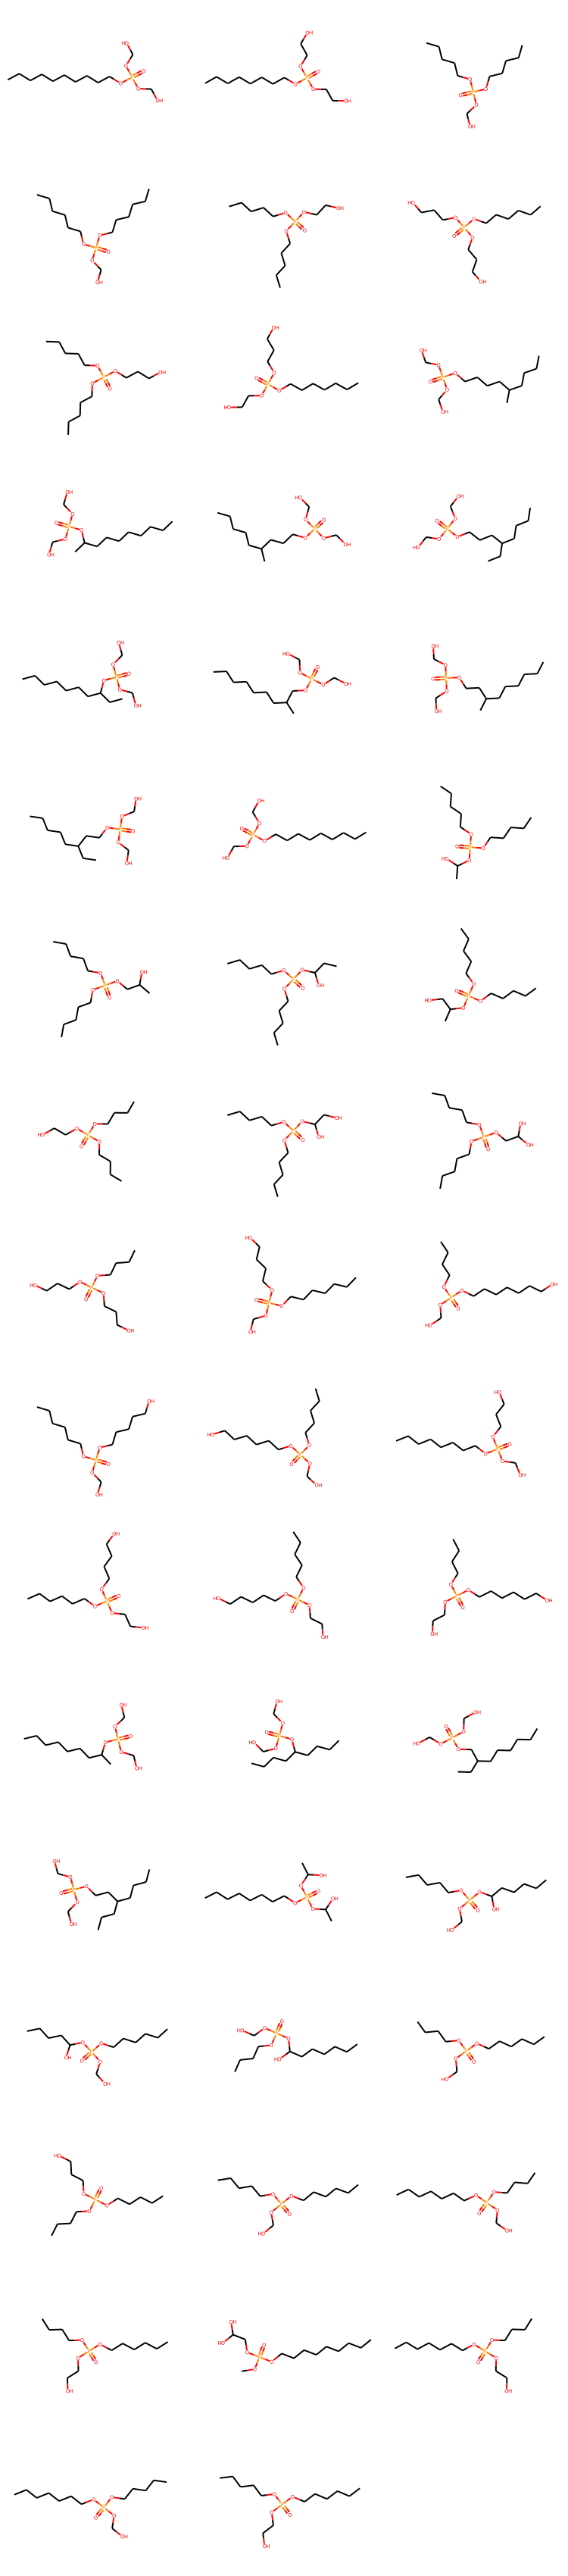

In [28]:
#Top 500 structures according to total score including synthesizability
#50 structures can be displayed at once
drawsmileslist(top500MAUT_PMTS['SMILES'][:50])

## Selected target molecule
From the manual inspection of the top scoring structures, the following molecule was identified as suitable target for synthesis and experimental testing. The linear C4-chains enable a systematic comparison with the original compounds TiBP and the hydroxyethanol side chain can be obtained from the readily available chemical ethyleneglycol. 

Original compound TiBP and Target 1:


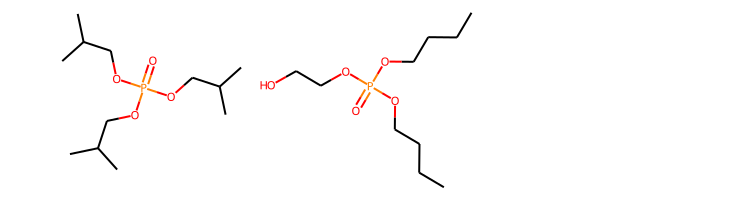

In [29]:
#define SMILES codes of the target molecule
tibp = 'O=P(OCC(C)C)(OCC(C)C)OCC(C)C' #original compound
target1 = 'CCCCOP(OCCCC)(OCCO)=O' 

print('Original compound TiBP and Target 1:')
show_mol_grid([Chem.MolFromSmiles(tibp),Chem.MolFromSmiles(target1)])

#### Show properties of selected target molecule

In [30]:
#Functions to identify specific molecules in dataframe
def showSMILESproperties(smiles, BigDF):
    '''Returns the row of the dataframe that corresponds to the input smiles, 
    by searching for the corresonding Inchi'''
    smii =Chem.MolToInchi(Chem.MolFromSmiles(smiles))
    smii_props = BigDF[BigDF['Inchi']== smii]
    return smii_props

In [31]:
target1_in_bigdf =showSMILESproperties(target1, BigDF)
target1_in_bigdf[['SMILES','log Kow', 'BCF', 'log Koc_av',
       'Non-Mutagenic Score', 'Biowin3','Biowin5', 'Biowin6', 'Biowin7',
       'Biowin7_MAUTscore','ReadyBiodegBW36_MAUTscore', 
       'log Kow_MAUTscore', 'log Koc_av_MAUTscore','Non-Mutagenic Score_MAUTscore',
        'total_PMTscore', 'total_PMTrank',
       'SynSymPoints', 'SynRingPoints', 'total_PMTSscore', 'total_PMTSrank']]

,SMILES,log Kow,BCF,log Koc_av,Non-Mutagenic Score,Biowin3,Biowin5,Biowin6,Biowin7,Biowin7_MAUTscore,ReadyBiodegBW36_MAUTscore,log Kow_MAUTscore,log Koc_av_MAUTscore,Non-Mutagenic Score_MAUTscore,total_PMTscore,total_PMTrank,SynSymPoints,SynRingPoints,total_PMTSscore,total_PMTSrank
7097,CCCCOP(=O)(OCCO)OCCCC,1.37,0.5583,2.104066,0.675,3.5477,0.6677,0.6889,0.9092,0.346947,0.59112,1.0,1.0,0.617647,0.77167,266.0,0.5,0.0,0.667336,22.0


## Plots for analysis

#### Stackplot to visualize contributions of each property to total MAUT score

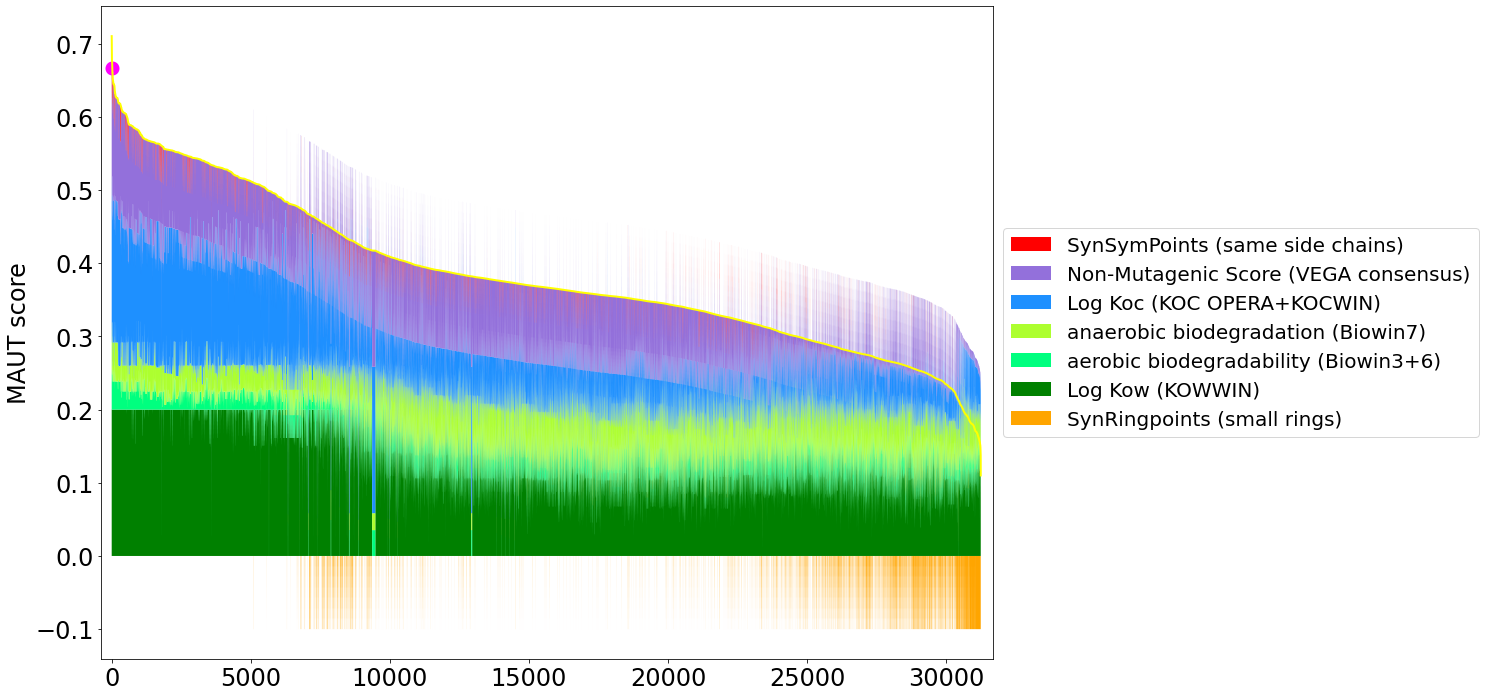

In [32]:
#specify here the df to plot
BigDF2 = BigDF.copy()
BigDF2 = BigDF2.sort_values("total_PMTSscore", ascending=False).reset_index(drop=True)

fig=plt.figure(figsize=(16, 12), facecolor='w', edgecolor='k')

Des_score_labels = ['SynRingpoints (small rings)','Log Kow (KOWWIN)', 'aerobic biodegradability (Biowin3+6)',
                    'anaerobic biodegradation (Biowin7)', 'Log Koc (KOC OPERA+KOCWIN)',
                    'Non-Mutagenic Score (VEGA consensus)', 
                    'SynSymPoints (same side chains)']
                    # ,'BCF_MAUTscore']
plt.stackplot(BigDF2.index, 
              normalize_factor_PMTS*weight_ring*BigDF2['SynRingPoints'],
              labels=Des_score_labels, colors = ['orange',
                                                'tab:pink'
                                            ])

plt.stackplot(BigDF2.index, normalize_factor_PMTS*weight_logKow*BigDF2['log Kow_MAUTscore'],
              normalize_factor_PMTS*weight_BW36*BigDF2['ReadyBiodegBW36_MAUTscore'],
              normalize_factor_PMTS*weight_BW7*BigDF2['Biowin7_MAUTscore'], 
              normalize_factor_PMTS*weight_logKoc*BigDF2['log Koc_av_MAUTscore'],
              normalize_factor_PMTS*weight_NonMuta*BigDF2['Non-Mutagenic Score_MAUTscore'],
              normalize_factor_PMTS*weight_sym*BigDF2['SynSymPoints'],
              labels=Des_score_labels, colors = ['green',
                                                'springgreen',
                                                'greenyellow',
                                                'dodgerblue',
                                                'mediumpurple',
                                                'red',
                                                'orange',
                                                'tab:pink'
                                            ])


#include target one as dot
plt.scatter(target1_in_bigdf["total_PMTSrank"],target1_in_bigdf["total_PMTSscore"], 
            color='magenta', linewidths=8)

plt.plot(BigDF2.index,BigDF2["total_PMTSscore"], color='yellow', linewidth=2)

#draw line at top 500
#plt.axvline(x=500, color='lightgrey')
#plt.axhline(y=0.675, color='lightgrey')
#draw line at target 1 desirability score
#plt.axhline(y=float(target1_in_bigdf["MAUTtotalPlusSynSymRingPoints"]), color='c')

plt.ylabel('MAUT score', fontsize=24)
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.legend(reversed(plt.legend().legendHandles), reversed(Des_score_labels),loc='center left', 
           bbox_to_anchor=(1, 0.5), fontsize=20)
plt.xlim(-400,31700)
#plt.tight_layout()
#plt.savefig('stackall_sorted_kow1', dpi=100,bbox_inches='tight')
plt.show()

Taget in magenta, lines represent the top 500 structures selected for manual inspected and the corresponding MAUT score.

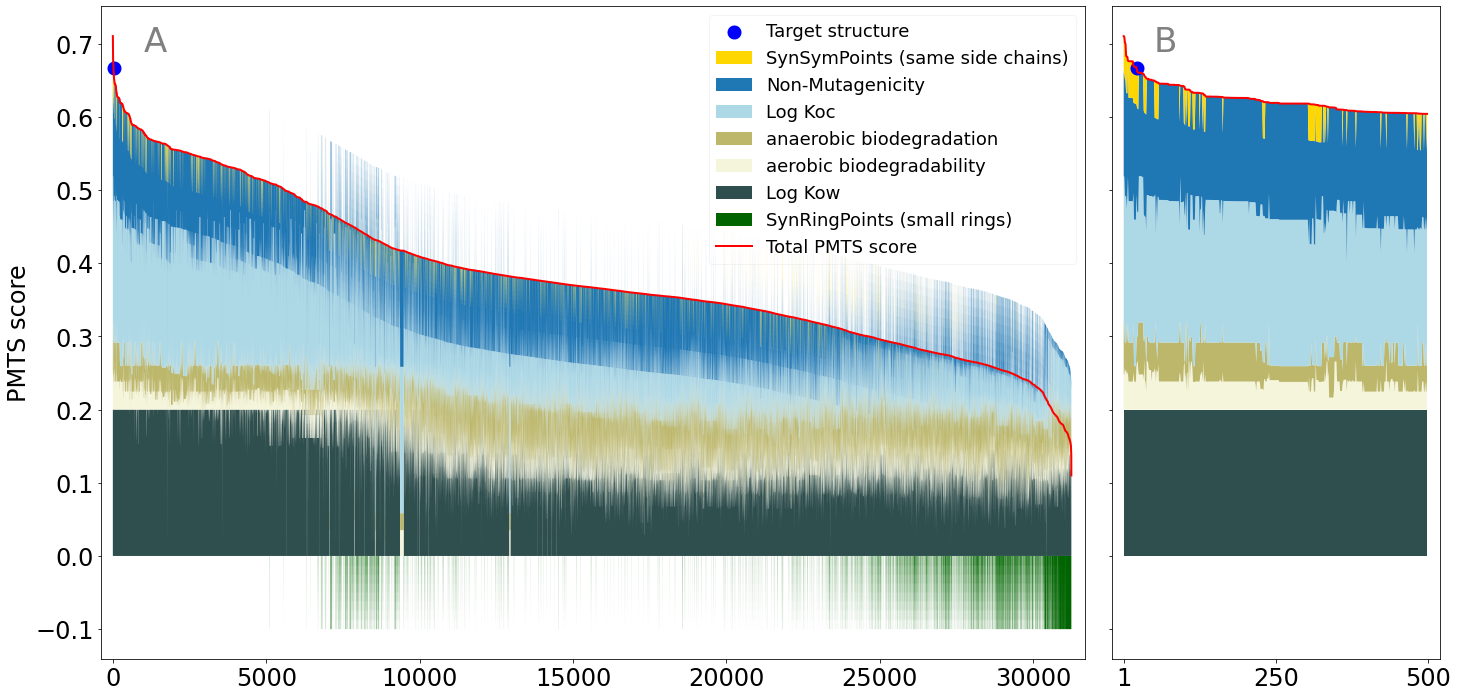

In [218]:
#specify here the df to plot
BigDF2 = BigDF2.sort_values("total_PMTSscore", ascending=False).reset_index(drop=True)

fig=plt.figure(figsize=(24, 12), facecolor='w', edgecolor='k')
gs = fig.add_gridspec(1,2, wspace=0.04, width_ratios= [3,1])

plt1 = fig.add_subplot(gs[0,0])
top = fig.add_subplot(gs[0,1])
col = ['darkslategray',
       'beige',
        'darkkhaki',
        'lightblue',
         'tab:blue',
        #'lavenderblush',
         'gold']

Des_score_labels = ['Total PMTS score','SynRingPoints (small rings)','Log Kow', 'aerobic biodegradability',
                    'anaerobic biodegradation', 'Log Koc',
                    'Non-Mutagenicity', 
                    'SynSymPoints (same side chains)', 'Target structure']
                    # ,'BCF_MAUTscore']

plt1.stackplot(BigDF2.index, 
              normalize_factor_PMTS*weight_ring*BigDF2['SynRingPoints'],
              labels=Des_score_labels, colors = ['darkgreen'
                                            ])

plt1.stackplot(BigDF2.index, normalize_factor_PMTS*weight_logKow*BigDF2['log Kow_MAUTscore'],
              normalize_factor_PMTS*weight_BW36*BigDF2['ReadyBiodegBW36_MAUTscore'],
              normalize_factor_PMTS*weight_BW7*BigDF2['Biowin7_MAUTscore'], 
              normalize_factor_PMTS*weight_logKoc*BigDF2['log Koc_av_MAUTscore'],
              normalize_factor_PMTS*weight_NonMuta*BigDF2['Non-Mutagenic Score_MAUTscore'],
              normalize_factor_PMTS*weight_sym*BigDF2['SynSymPoints'],
              labels=Des_score_labels, colors = col)


#include target one as dot
plt1.scatter(target1_in_bigdf["total_PMTSrank"],target1_in_bigdf["total_PMTSscore"], 
            color='b', linewidths=8, label='target')

plt1.plot(BigDF2.index,BigDF2["total_PMTSscore"], color='r', linewidth=2, label='total score')

#draw line at top 500
#plt.axvline(x=500, color='lightgrey')
#plt.axhline(y=0.675, color='lightgrey')
#draw line at target 1 desirability score
#plt.axhline(y=float(target1_in_bigdf["MAUTtotalPlusSynSymRingPoints"]), color='c')

plt1.set_ylabel('PMTS score', fontsize=24)
plt1.tick_params(labelsize=24)
handles, labels = plt1.get_legend_handles_labels()
legend = plt1.legend(reversed(handles), reversed(Des_score_labels),loc='upper right',fontsize=18)
legend.get_frame().set_alpha(0.2)

plt1.set_xlim(-400,31700)

#top
BigDF2top = BigDF2.head(500)
top.stackplot(BigDF2top.index, normalize_factor_PMTS*weight_logKow*BigDF2top['log Kow_MAUTscore'],
              normalize_factor_PMTS*weight_BW36*BigDF2top['ReadyBiodegBW36_MAUTscore'],
              normalize_factor_PMTS*weight_BW7*BigDF2top['Biowin7_MAUTscore'], 
              normalize_factor_PMTS*weight_logKoc*BigDF2top['log Koc_av_MAUTscore'],
              normalize_factor_PMTS*weight_NonMuta*BigDF2top['Non-Mutagenic Score_MAUTscore'],
              normalize_factor_PMTS*weight_sym*BigDF2top['SynSymPoints'],
              labels=Des_score_labels, colors = col)

top.stackplot(BigDF2.index, 
              normalize_factor_PMTS*weight_ring*BigDF2['SynRingPoints'],
              labels=Des_score_labels, colors = ['orange',
                                                'tab:pink'
                                            ])

#include target one as dot
top.scatter(target1_in_bigdf["total_PMTSrank"],target1_in_bigdf["total_PMTSscore"], 
            color='b', linewidths=8)

top.plot(BigDF2top.index,BigDF2top["total_PMTSscore"], color='r', linewidth=2)
top.set_xlim(-20,520)
top.tick_params(labelsize=24)
top.set_xticks([1,250,500])
top.set_yticklabels('')


#label plots
top.annotate('B', xy = (50, 0.69 ), 
             fontsize = 34, color = 'grey')
plt1.annotate('A', xy = (1000, 0.69 ), 
             fontsize = 34, color = 'grey')

#plt.tight_layout()
#plt.savefig('stackall_sorted_kow1', dpi=100,bbox_inches='tight')
plt.show()

#### Desity plots of the property distribution of the whole dataset and the top 500 compounds

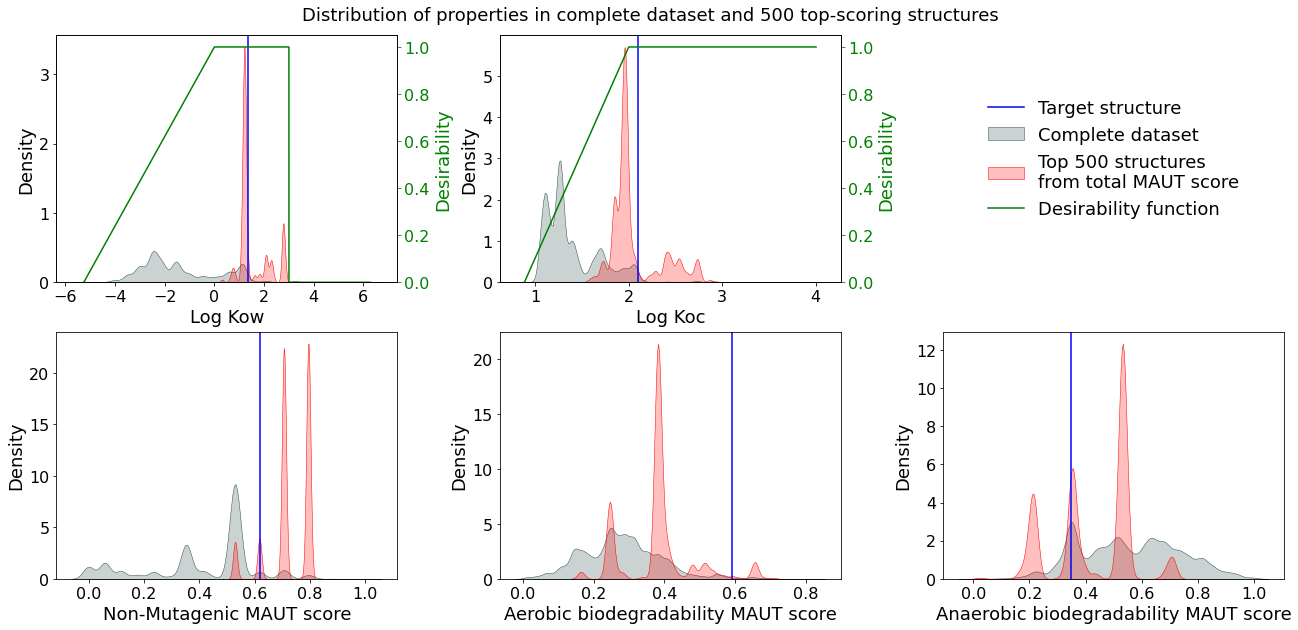

In [158]:
fig = plt.figure(figsize=(22, 10), facecolor='w', edgecolor='k')
gs = fig.add_gridspec(2,3, hspace=0.2,wspace=0.3, height_ratios= [1,1])

#style parameter
font_s = 18
font_s_tick = 16

#fig.subplots_adjust(hspace=0.4, wspace=0.4)
subplot1 = fig.add_subplot(gs[0, 0])
subplot2 = fig.add_subplot(gs[0, 1])
subplot3 = fig.add_subplot(gs[1, 0])
subplot4 = fig.add_subplot(gs[1, 1])
subplot5 = fig.add_subplot(gs[1, 2])
leg_plot = fig.add_subplot(gs[0, 2])

def make_kdeplot(prop, proptitle, df, dftop500,subplot, bw=0.1, bwtop=0.1):
    ax = subplot
    sns.kdeplot(df[prop], shade=True, color="darkslategrey", linewidth=0.5,bw=bw, ax=ax, 
                 label='Complete dataset')
    sns.kdeplot(dftop500[prop], shade=True, color="r", linewidth=0.5,
                 bw=bwtop, ax=ax, label='Top 500 structures \nfrom total MAUT score')
    ax.tick_params(labelsize=font_s_tick)
    #ax.set_ylim(0,1)

    #ax.xaxis.set_ticks(np.arange(-6, 12, 2))
    ax.set_xlabel(proptitle,fontsize=font_s)
    ax.set_ylabel('Density',fontsize=font_s)
    
    ax.axvline(x=target1_in_bigdf[prop].reset_index(drop=True)[0], label='Target structure', color='b')
    
    plt.tight_layout()


make_kdeplot('log Kow', 'Log Kow', BigDF2, BigDF2.head(500),subplot1)
make_kdeplot('log Koc_av', 'Log Koc', BigDF2, BigDF2.head(500),subplot2)
make_kdeplot('Non-Mutagenic Score_MAUTscore', 'Non-Mutagenic MAUT score', BigDF2, BigDF2.head(500),subplot3)
make_kdeplot('ReadyBiodegBW36_MAUTscore', 'Aerobic biodegradability MAUT score', BigDF2, BigDF2.head(500),subplot4)
make_kdeplot('Biowin7_MAUTscore', 'Anaerobic biodegradability MAUT score', BigDF2, BigDF2.head(500),subplot5)

#subplot1.set_ylim(0,2)
ax2 = subplot1.twinx()
ax2.set_ylim(0,1.05)
ax2.set_ylabel('Desirability',fontsize=font_s)
ax2.tick_params(labelsize=font_s_tick, colors='g')
ax2.yaxis.label.set_color('g')
ax2.plot(logKow_desirability['x'],f_logKow(logKow_desirability['x']), color='g',
             label='Desirability function')

ax3 = subplot2.twinx()
ax3.set_ylim(0,1.05)
ax3.set_ylabel('Desirability',fontsize=font_s)
ax3.tick_params(labelsize=font_s_tick, colors='g')
ax3.yaxis.label.set_color('g')
ax3.plot(logKoc_desirability['x'],f_logKoc(logKoc_desirability['x']), color='g',
             label='Desirability function')

# ask matplotlib for the plotted objects and their labels
lines, labels = subplot1.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
#make legend
leg_plot.legend(lines+lines2, labels+labels2, loc='center', fontsize=18, frameon=False)
leg_plot.axis('off')

fig.suptitle('Distribution of properties in complete dataset and 500 top-scoring structures', fontsize=18,y=0.92)

plt.show()

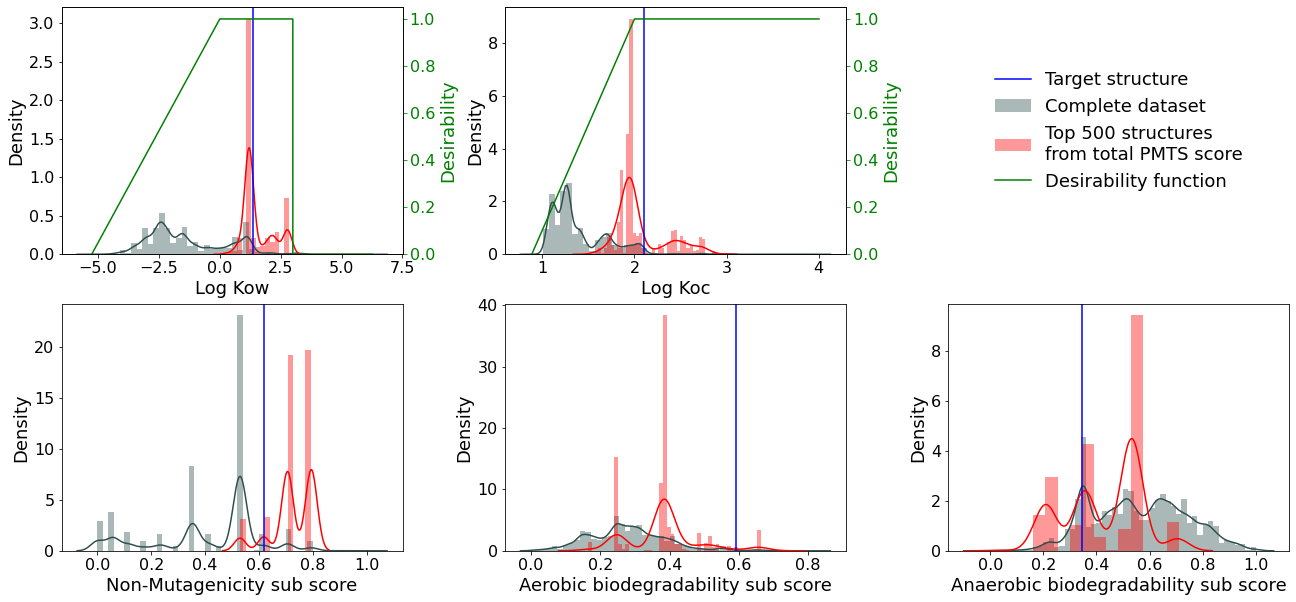

In [216]:
fig = plt.figure(figsize=(22, 10), facecolor='w', edgecolor='k')
gs = fig.add_gridspec(2,3, hspace=0.2,wspace=0.3, height_ratios= [1,1])

#style parameter
font_s = 18
font_s_tick = 16

#fig.subplots_adjust(hspace=0.4, wspace=0.4)
subplot1 = fig.add_subplot(gs[0, 0])
subplot2 = fig.add_subplot(gs[0, 1])
subplot3 = fig.add_subplot(gs[1, 0])
subplot4 = fig.add_subplot(gs[1, 1])
subplot5 = fig.add_subplot(gs[1, 2])
leg_plot = fig.add_subplot(gs[0, 2])

def make_kdeplot(prop, proptitle, df, dftop500,subplot, bins=40):
    ax = subplot
    sns.distplot(df[prop], hist=True, kde=True,  ax=ax,color='darkslategray',
                 label='Complete dataset')
    sns.distplot(dftop500[prop], hist=True, kde=True, ax=ax, label='Top 500 structures \nfrom total PMTS score',
                color='r')
    ax.tick_params(labelsize=font_s_tick)
    #ax.set_ylim(0,1)

    #ax.xaxis.set_ticks(np.arange(-6, 12, 2))
    ax.set_xlabel(proptitle,fontsize=font_s)
    ax.set_ylabel('Density',fontsize=font_s)
    
    ax.axvline(x=target1_in_bigdf[prop].reset_index(drop=True)[0], label='Target structure', color='b')
    
    plt.tight_layout()


make_kdeplot('log Kow', 'Log Kow', BigDF2, BigDF2.head(500),subplot1)
make_kdeplot('log Koc_av', 'Log Koc', BigDF2, BigDF2.head(500),subplot2)
make_kdeplot('Non-Mutagenic Score_MAUTscore', 'Non-Mutagenicity sub score', BigDF2, BigDF2.head(500),subplot3)
make_kdeplot('ReadyBiodegBW36_MAUTscore', 'Aerobic biodegradability sub score', BigDF2, BigDF2.head(500),subplot4)
make_kdeplot('Biowin7_MAUTscore', 'Anaerobic biodegradability sub score', BigDF2, BigDF2.head(500),subplot5)

#subplot1.set_ylim(0,2)
ax2 = subplot1.twinx()
ax2.set_ylim(0,1.05)
ax2.set_ylabel('Desirability',fontsize=font_s)
ax2.tick_params(labelsize=font_s_tick, colors='g')
ax2.yaxis.label.set_color('g')
ax2.plot(logKow_desirability['x'],f_logKow(logKow_desirability['x']), color='g',
             label='Desirability function')

ax3 = subplot2.twinx()
ax3.set_ylim(0,1.05)
ax3.set_ylabel('Desirability',fontsize=font_s)
ax3.tick_params(labelsize=font_s_tick, colors='g')
ax3.yaxis.label.set_color('g')
ax3.plot(logKoc_desirability['x'],f_logKoc(logKoc_desirability['x']), color='g',
             label='Desirability function')

# ask matplotlib for the plotted objects and their labels
lines, labels = subplot1.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
#make legend
leg_plot.legend(lines+lines2, labels+labels2, loc='center', fontsize=18, frameon=False)
leg_plot.axis('off')

#fig.suptitle('Distribution of properties in complete dataset and 500 top-scoring structures', fontsize=18,y=0.92)

plt.show()

In [176]:
for prop in ['Non-Mutagenic Score_MAUTscore','ReadyBiodegBW36_MAUTscore','Biowin7_MAUTscore', 'log Koc_av_MAUTscore', 'log Kow_MAUTscore']:
    maxi = BigDF2.head(500)[prop].max()
    mini = BigDF2.head(500)[prop].min()
    perc = (maxi-mini)/maxi
    print(prop, perc, '\n',mini, maxi,'\n',)

Non-Mutagenic Score_MAUTscore 0.33333333333333326 
 0.5294117647058824 0.7941176470588235 

ReadyBiodegBW36_MAUTscore 0.7677828144893014 
 0.16417224383728685 0.706977149327836 

Biowin7_MAUTscore 0.9651917404129793 
 0.02476910159529807 0.7115869017632243 

log Koc_av_MAUTscore 0.38732804588430336 
 0.6126719541156966 1.0 

log Kow_MAUTscore 0.0 
 1.0 1.0 

